In [96]:
import micasense.imageset as imageset
import micasense.capture as capture
import os, glob
import json
import tqdm
import pickle #This library will maintain the format as well
import importlib
import radiometric_calib_utils
importlib.reload(radiometric_calib_utils)
import radiometric_calib_utils as rcu
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

d:\PAKHUIYING\Image_processing\F3_raw_images\Simulate_sun_glint\radiometric_calib_utils.py:25: DeprecationWarning: invalid escape sequence \s
  given the directory, find all the panel images in the subdirectories and save the filepaths in a dictionary


## Opening Images

As we have done in previous examples, we use the micasense.capture class to open, radiometrically correct, and visualize the 10 bands of a RedEdge-MX Dual (Red+Blue) capture.

First, we'll load the `autoreload` extension.  This lets us change underlying code (such as library functions) without having to reload the entire workbook and kernel. This is useful in this workbook because the cell that runs the alignment can take a long time to run, so with `autoreload` extension we can update the code after the alignment step for analysis and visualization without needing to re-compute the alignments each time.

In [1]:
%load_ext autoreload
%autoreload 2

This notebook aims to create a calibration curve for radiometric correction under different illumination conditions. Without effective radiometric calibration, drone imagery heavily suffers from sun illumination affected by time of day, cloud, and other weather conditions. UAV sensors are vulnerable to vibration and wind effect during flight. Their radiometric properties may also be impacted by other environmental variations such as temperature, solar illumination, and weather conditions. Therefore, even with calibrated sensors, in situ calibration is often needed to improve accuracies of quantitative applications.

The most common in situ calibration approach is the Empirical Line Method (ELM) to build the relationships between the reflectance of calibrated targets and their top-of-atmosphere radiance (at sensor radiance). It requires the real-time reflectance measurements of multiple artificial or natural targets. Some studies explored the irradiance-based ELM calibration by considering the aerosol effects in the relationship. This empirical calibration is often time consuming and not practical efficient. The real-time field spectra may not be needed when a reference standard is employed in field. The RedEdge system utilises a pre-calibration reflectance panel (CRP) set up in field and a Downwelling Light Sensor (DLS) mounted atop a drone to capture the hemispherical irradiance during the flight. The current procedure of RedEdge image correction mostly utilises the CRP panel itself and some studies have reported the relatively higher percent errors of its radiometric calibration. With the bar code embedded on the panel, the CRP reflectance can be automatically recognised in image processing packages.

## Radiometric calibration model

A radiometric calibration model has been has been developed to convert the raw pixel values into absolute spectral radiance:

$$ L = V(x,y) \cdot \frac{a_1}{g} \cdot \frac{p - p_{BL}}{t_e + a_2 y -a_3 t_e y}$$

Where,

- $p$ is the normalised raw pixel value (0 to 1 by dividing DN with the number of bits)
- $p_{BL}$ is the normalised black level value (can be found in metadata tags). This tag encodes an array of 4 values, which should be averaged to compute a black level offset which can be applied to all pixels
- $a_1, a_2, a_3$ are the radiometric calibration coefficients (to convert DN to radiance)
- $V(x,y)$ is the vignette polynomial function for pixel location (x,y). See "Vignette Model" section
- $t_e$ is the image exposure time
- $g$ is the sensor gain setting (can be found in metadata tags)
- $x, y$ are the pixel column and row number, respectively
- $L$ is the spectral radiance in $W/m^2/sr/nm$

## Vignette Model

The RedEdge uses a radial vignette model to correct for the fall-off in light sensitivity that occurs in pixels further from the center of the image. To apply the model, first read $cx, cy$ and the six polynomial coefficients from the image metadata, then compute the formula below to find a correction scale factor for each pixel intensity

$r = \sqrt{(x-c_x)^2 + (y-c_y)^2}$

$k = 1 + k_0 * r + k_1 * r^2 + k_2 * r^3 + k_3 * r^4 + k^4 * r^5 + k_5 * r^6$

$I_{corrected}(x,y) = \frac{I(x,y)}{k}$

Where,

- $r$ is the distance of the pixel (x,y) from the vignette center, in pixels
- $(x,y)$ is the coordinate of the pixel being corrected
- $k$ is the correction factor by which the raw pixel value should be divided to correct for vignette
- $I(x,y)$ is the original intensity of pixel at $x,y$
- $I_{corrected}(x,y)$ is the corrected intensity of pixel at x,y

In the radiance model above, $V(x,y)$ is equal to $1/k$

## Radiometric Correction

The radiance after calibration is further converted to surface reflectance for spectral analysis. Assisted with a pre-calibrated CRP panel, the surface reflectance ($\rho$) of the RedEdge-M image can be simply converted as:

$$ \rho(\lambda) = \frac{\rho_{CRP}}{L_{CRP}} \times L(\lambda) \quad (1)$$

Where,
- $\frac{\rho_{CRP}}{L_{CRP}}$ is the reflectance calibration factor to convert radiance of an image to reflectance
- $\rho_{CRP}$ is the pre-calibrated reflectance of the CRP panel
- $L_{CRP}$ is the average radiance of the CRP panel
- $\rho(\lambda)$ is the reflectance of an image of interest
- $L$ is the radiance of an image of interest

These micasense imageprocessing tool scan the QR code and identify a squared area within the CRP panel, then calculate the average radiance. The reflectance calibration factor us aookued to all pixels of the image to extract surface reflectance

This approach is easy to use and works well when the relative biophysical quantities are of major concern. However, the radiometric correction relies on one single panel with a pre-determined constant coefficient for each band. In field, the panel's reflectance may be affected by solar illumination and path scattering that vary with time and atmospheric and environmental conditions. Therefore, a more rigid radiometric correction method is needed to better calculate the reflective values of the images

## At-sensor DLS Radiometric Correction

The camera takes the CRP calibration images on ground before and after a flight mission. The image records the radiance reflected out of the CRP panel, which can be transformed to the incoming irradiances of each band given the known reflectance of the diffuse material. At the same time, the Downwelling Light Sensor (DLS) records the incoming irradiance in each band at a unit $W/m^2/nm$. The irradiance recordings are stored as metadata of each image.

Influenced by the mechanical differences between the two sensors and environmental scattering, the two irradiance recordings would not be identical but should follow a linear relationship:

$$ Irr_{CRP}(\lambda) = a \times Irr_{DLS}(\lambda) + b $$

Where,

- $Irr_{CRP}(\lambda)$ represent the camera-recorded irradiance reaching the CRP
- $Irr_{DLS}(\lambda)$ represent the DLS-recorded irradiance atop the drone (Note the DLS is installed upward facing the direct sky)
- coefficients $a,b$ represents the differences between the two sensors

The CRP is made of diffuser materials that are supposed to have equal radiance in all directions. The $Irr_{CRP}(\lambda)$ can thus be simplified as the CRP radiance multiplied by $\pi$. Similarly, the DLS radiance can be calculated as the $Irr_{DLS}(\lambda)$ divided by $\pi$.

For a known reflectance of the diffuse material ($\rho_{CRP}$ which varies from 0 to 1), the corresponding radiance is thus $L_{CRP}$, thus the irradiance (i.e. 100% reflectance) is thus: $\frac{L_{CRP}(\lambda)}{\rho_{CRP}}$

$$ \frac{\pi L_{CRP}(\lambda)}{\rho_{CRP}} = a \times \pi L_{DLS}(\lambda) + b $$

Dividing by $\pi$

$$ \frac{L_{CRP}(\lambda)}{\rho_{CRP}} = a \times L_{DLS}(\lambda) + \frac{b}{\pi} \quad (2)$$

Substituting (2) in (1),

and $\rho (\lambda) = \frac{\rho_{CRP}}{L_{CRP}} \times L(\lambda)$, thus $L(\lambda) = \frac{\rho(\lambda) L_{CRP}}{\rho_{CRP}}$

$$\rho_{cor}(\lambda) = \frac{a}{1- \frac{b \times \rho_{CRP}}{\pi L_{CRP}(\lambda)}} \times \rho (\lambda)$$

where $Cor(\lambda) = \frac{a}{1- \frac{b \times \rho_{CRP}}{\pi L_{CRP}(\lambda)}}$ is the correction factor applied to each flight mission. Since $\rho_{CRP}$ is pre-determined, and $L_{CRP}$ is mission specific and is extracted from the panel calibration image of a flight mission. We just need to solve for $a,b$ from the CRP_DLS irradiance regression. Both CRP and DLS are made of diffuse materials and therefore possess a common relationshop between their irradiance recordings. The study relies on all calibration data collected in multiple flights at different study sites to build the CRP-DLS relationship.

# Import panels

In [3]:
panel_fp = rcu.load_panel_fp(r"saved_data\panel_fp.json")
panel_fp

{'F:\\surveys_10band\\10thSur24Aug\\F1\\RawImg': [['F:\\surveys_10band\\10thSur24Aug\\F1\\RawImg\\IMG_0000_1.tif',
   'F:\\surveys_10band\\10thSur24Aug\\F1\\RawImg\\IMG_0000_2.tif',
   'F:\\surveys_10band\\10thSur24Aug\\F1\\RawImg\\IMG_0000_3.tif',
   'F:\\surveys_10band\\10thSur24Aug\\F1\\RawImg\\IMG_0000_4.tif',
   'F:\\surveys_10band\\10thSur24Aug\\F1\\RawImg\\IMG_0000_5.tif',
   'F:\\surveys_10band\\10thSur24Aug\\F1\\RawImg\\IMG_0000_6.tif',
   'F:\\surveys_10band\\10thSur24Aug\\F1\\RawImg\\IMG_0000_7.tif',
   'F:\\surveys_10band\\10thSur24Aug\\F1\\RawImg\\IMG_0000_8.tif',
   'F:\\surveys_10band\\10thSur24Aug\\F1\\RawImg\\IMG_0000_9.tif',
   'F:\\surveys_10band\\10thSur24Aug\\F1\\RawImg\\IMG_0000_10.tif'],
  ['F:\\surveys_10band\\10thSur24Aug\\F1\\RawImg\\IMG_0585_1.tif',
   'F:\\surveys_10band\\10thSur24Aug\\F1\\RawImg\\IMG_0585_2.tif',
   'F:\\surveys_10band\\10thSur24Aug\\F1\\RawImg\\IMG_0585_3.tif',
   'F:\\surveys_10band\\10thSur24Aug\\F1\\RawImg\\IMG_0585_4.tif',
   'F:\\surv

In [111]:
panel_albedo = rcu.load_pickle(r"saved_data\panel_albedo.ob")
center_wavelengths = rcu.load_pickle(r"saved_data\center_wavelengths_by_band.ob")
dls_panel_irr = rcu.load_pickle(r"saved_data\dls_panel_irr.ob")
dls_panel_irr_calibration = rcu.load_pickle(r"saved_data\dls_panel_irr_calibration.ob")
print(panel_albedo)
print(center_wavelengths)

[0.48112499999999997, 0.4801333333333333, 0.4788733333333333, 0.4768433333333333, 0.4783016666666666, 0.4814866666666666, 0.48047166666666663, 0.4790833333333333, 0.47844166666666665, 0.4780333333333333]
[475, 560, 668, 842, 717, 444, 531, 650, 705, 740]


In [113]:
class RadiometricCorrection:
    def __init__(self,dls_panel_irr,center_wavelengths,dls_panel_irr_calibration=None):
        self.dls_panel_irr = dls_panel_irr
        self.number_of_bands = 10
        self.center_wavelengths = center_wavelengths
        self.dls_panel_irr_calibration=dls_panel_irr_calibration

    def get_dls_panel_irr_by_band(self):
        panel_irr = {i:[] for i in range(self.number_of_bands)}
        dls_irr = {i:[] for i in range(self.number_of_bands)}
        for k, list_of_d in self.dls_panel_irr.items():
            for d in list_of_d:
                for i,dls in enumerate(d['dls']):
                    dls_irr[i].append(dls)
                for i,panel in enumerate(d['panel']):
                    panel_irr[i].append(panel)
        return {'dls':dls_irr,'panel':panel_irr}

    def plot(self):
        dls_panel_irr_by_band = self.get_dls_panel_irr_by_band()
        if dls_panel_irr_calibration is None:
            model_coeff = self.fit_curve_by_band()
        else:
            model_coeff = dls_panel_irr_calibration
        fig, axes = plt.subplots(self.number_of_bands//2,2,figsize=(8,15))
        for i,ax in zip(range(self.number_of_bands),axes.flatten()):
            x = dls_panel_irr_by_band['dls'][i]
            y = dls_panel_irr_by_band['panel'][i]
            ax.plot(x,y,'o')
            ax.set_title(r'Band {} nm ($R^2:$ {:.3f}, N = {})'.format(self.center_wavelengths[i],model_coeff[i]['r2'],len(x)))
            ax.set_xlabel(r'DLS irradiance $W/m^2/nm$')
            ax.set_ylabel(r'Panel irradiance $W/m^2/nm$')
            x_vals = np.linspace(np.min(x),np.max(x),50)
            intercept = model_coeff[i]['intercept']
            slope = model_coeff[i]['coeff']
            y_vals = intercept + slope * x_vals
            ax.plot(x_vals.reshape(-1,1), y_vals.reshape(-1,1), '--')
            ax.text(0.1,ax.get_ylim()[1]*0.8,r"$y = {:.3f}x + {:.3f}$".format(slope,intercept))

        plt.tight_layout()
        return axes

    def fit_curve_by_band(self):
        dls_panel_irr_by_band = self.get_dls_panel_irr_by_band()
        model_coeff = dict()#{i: None for i in range(10)}
        for i in range(self.number_of_bands):
            x = np.array(dls_panel_irr_by_band['dls'][i]).reshape(-1, 1)
            y = np.array(dls_panel_irr_by_band['panel'][i]).reshape(-1, 1)
            lm = LinearRegression().fit(x, y)
            r2 = r2_score(y,lm.predict(x))
            model_coeff[i] = {'coeff':lm.coef_[0][0],'intercept':lm.intercept_[0],'r2':r2}
        
        return model_coeff

array([[<AxesSubplot:title={'center':'Band 475 nm ($R^2:$ 0.909, N = 95)'}, xlabel='DLS irradiance $W/m^2/nm$', ylabel='Panel irradiance $W/m^2/nm$'>,
        <AxesSubplot:title={'center':'Band 560 nm ($R^2:$ 0.913, N = 95)'}, xlabel='DLS irradiance $W/m^2/nm$', ylabel='Panel irradiance $W/m^2/nm$'>],
       [<AxesSubplot:title={'center':'Band 668 nm ($R^2:$ 0.917, N = 95)'}, xlabel='DLS irradiance $W/m^2/nm$', ylabel='Panel irradiance $W/m^2/nm$'>,
        <AxesSubplot:title={'center':'Band 842 nm ($R^2:$ 0.917, N = 95)'}, xlabel='DLS irradiance $W/m^2/nm$', ylabel='Panel irradiance $W/m^2/nm$'>],
       [<AxesSubplot:title={'center':'Band 717 nm ($R^2:$ 0.920, N = 95)'}, xlabel='DLS irradiance $W/m^2/nm$', ylabel='Panel irradiance $W/m^2/nm$'>,
        <AxesSubplot:title={'center':'Band 444 nm ($R^2:$ 0.887, N = 95)'}, xlabel='DLS irradiance $W/m^2/nm$', ylabel='Panel irradiance $W/m^2/nm$'>],
       [<AxesSubplot:title={'center':'Band 531 nm ($R^2:$ 0.895, N = 95)'}, xlabel='DLS irr

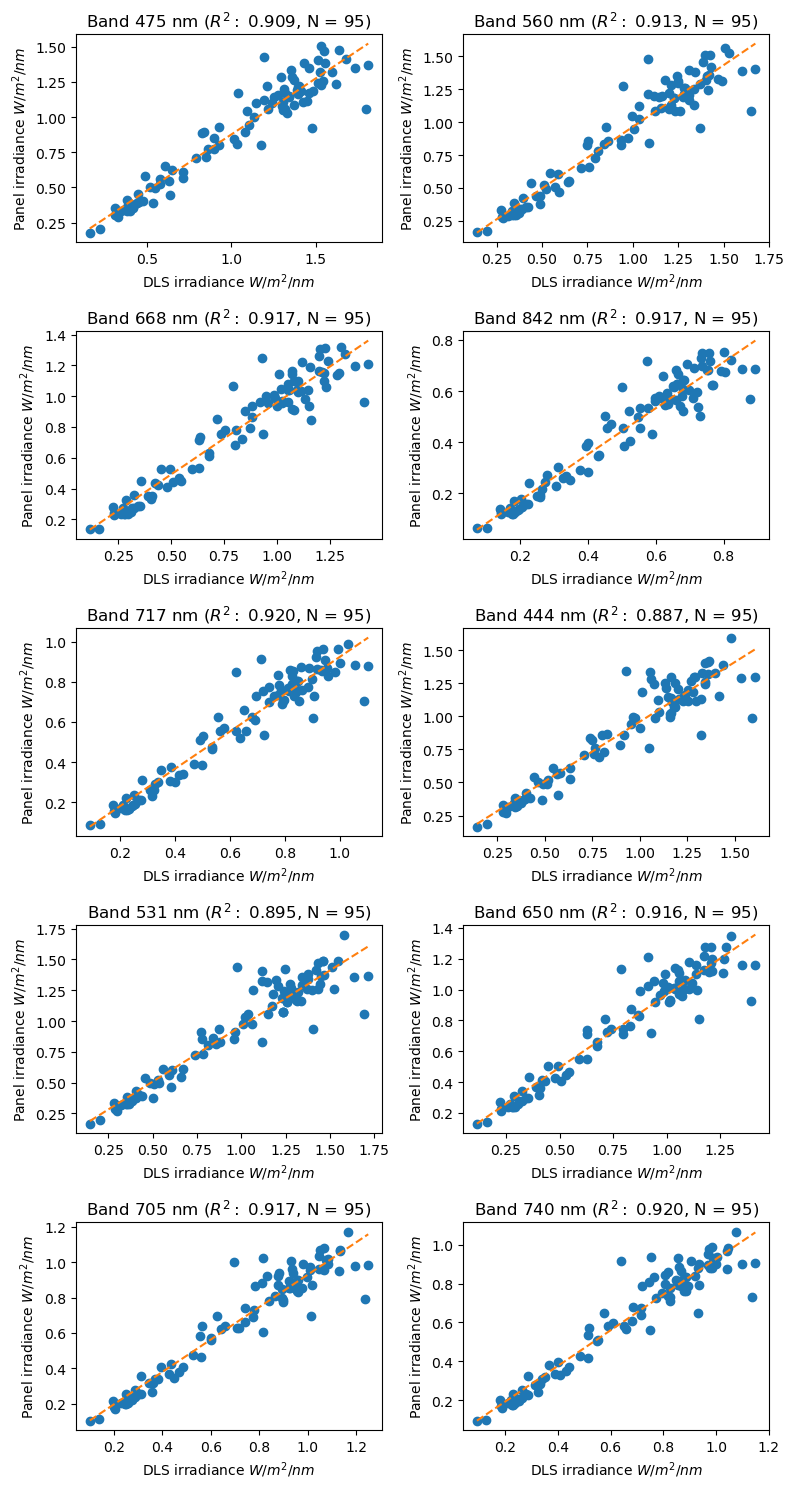

In [114]:
RC = RadiometricCorrection(dls_panel_irr,center_wavelengths,dls_panel_irr_calibration)
RC.plot()

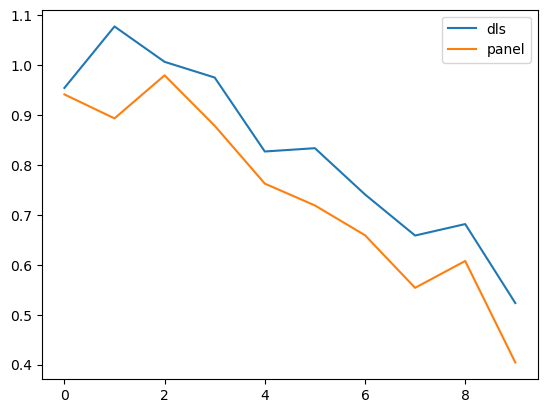

In [34]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot([i for i,w in sorted(zip(dls_panel_irr['dls'],center_wavelengths),key=lambda pair: pair[1])],label='dls')
plt.plot([i for i,w in sorted(zip(dls_panel_irr['panel'],center_wavelengths),key=lambda pair: pair[1])],label='panel')
plt.legend()
plt.show()

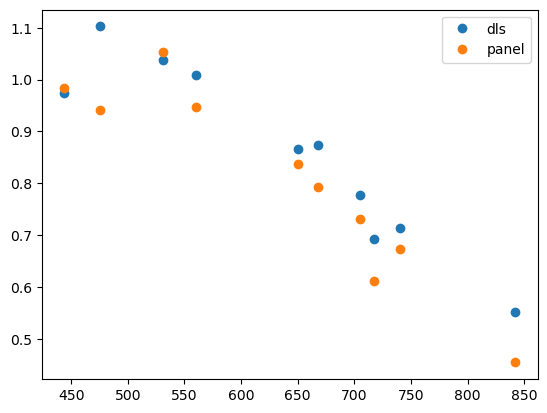

In [32]:
plt.figure()
plt.plot(center_wavelengths,dls_panel_irr['dls'],'o',label='dls')
plt.plot(center_wavelengths,dls_panel_irr['panel'],'o',label='panel')
plt.legend()
plt.show()